# 📊 Modélisation du prix des logements Airbnb avec XGBoost

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
import shap
import matplotlib.pyplot as plt
import seaborn as sns

shap.initjs()


## 🔍 Chargement et préparation des données

In [2]:

df = pd.read_csv("listings.csv")
df["price"] = df["price"].replace(r'[\$,]', '', regex=True).astype(float)

features = [
    "room_type", "minimum_nights", "number_of_reviews", "reviews_per_month",
    "availability_365", "accommodates", "bedrooms", "bathrooms", "beds",
    "property_type", "neighbourhood_cleansed", "latitude", "longitude"
]
target = "price"

df = df[features + [target]].dropna()
df = df[(df["price"] > 0) & (df["price"] < 1000)]
df = df[(df["minimum_nights"] <= 30) & (df["availability_365"] > 0)]

center_lat, center_long = df["latitude"].mean(), df["longitude"].mean()
df["distance_to_center"] = np.sqrt((df["latitude"] - center_lat)**2 + (df["longitude"] - center_long)**2)
df["reviews_per_year"] = df["reviews_per_month"] * 12
df["bed_per_guest"] = df["beds"] / df["accommodates"]
df["price_per_accommodate"] = df["price"] / df["accommodates"]
df["mean_price_by_neighbourhood"] = df.groupby("neighbourhood_cleansed")["price"].transform("mean")

X = df.drop(columns=["price"])
y = np.log1p(df["price"])


## 📈 Visualisations exploratoires

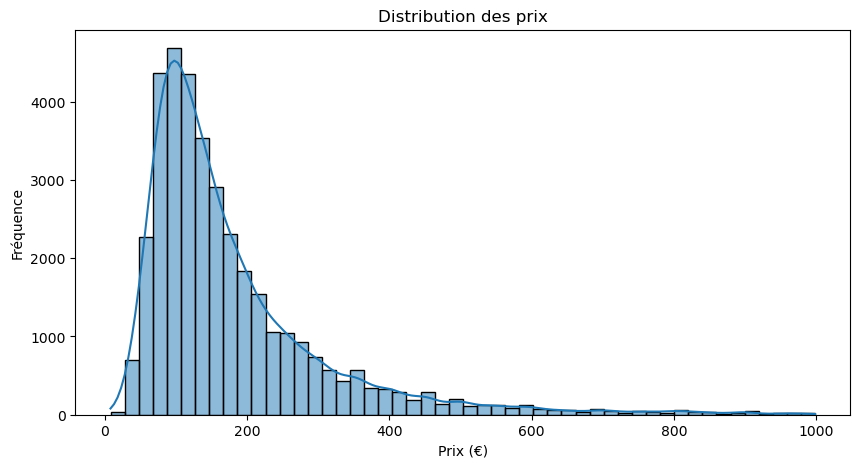

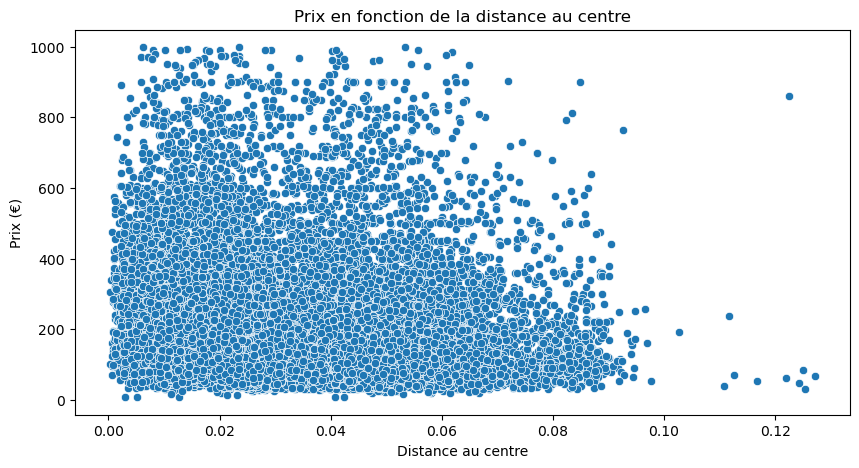

In [3]:

plt.figure(figsize=(10, 5))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution des prix")
plt.xlabel("Prix (€)")
plt.ylabel("Fréquence")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x="distance_to_center", y="price")
plt.title("Prix en fonction de la distance au centre")
plt.xlabel("Distance au centre")
plt.ylabel("Prix (€)")
plt.show()


## ⚙️ Prétraitement et pipeline XGBoost

In [4]:

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

xgb = XGBRegressor(random_state=42, verbosity=0)
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', xgb)
])

param_distributions = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


## 🧪 Évaluation du modèle

In [5]:

y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

r2_log = r2_score(y_test, y_pred_log)
r2_orig = r2_score(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mae = mean_absolute_error(y_test_orig, y_pred)

print("R² (log)     :", round(r2_log, 3))
print("R² (réel)    :", round(r2_orig, 3))
print("RMSE         :", round(rmse, 2), "€")
print("MAE          :", round(mae, 2), "€")


R² (log)     : 0.998
R² (réel)    : 0.994
RMSE         : 10.82 €
MAE          : 3.43 €


## 📊 Interprétation avec SHAP

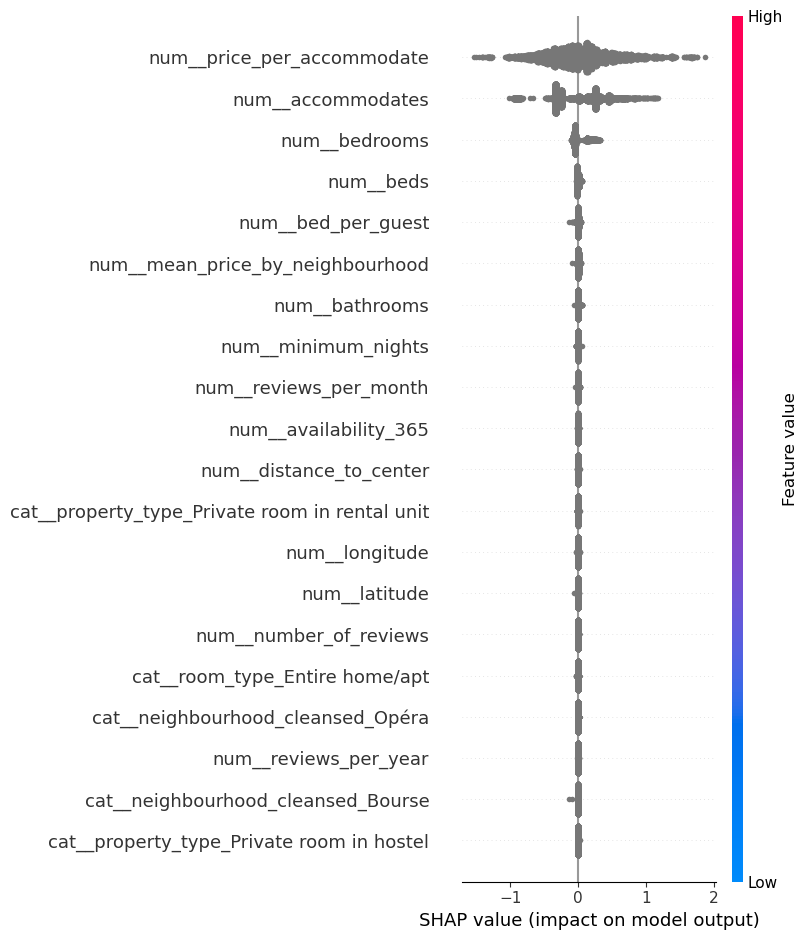

In [6]:

booster = best_model.named_steps["regressor"]
X_test_transformed = best_model.named_steps["preprocessing"].transform(X_test)

explainer = shap.Explainer(booster)
shap_values = explainer(X_test_transformed)

feature_names = best_model.named_steps["preprocessing"].get_feature_names_out()
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)
